<h1> SA spending  </h1>

In [24]:
from __future__ import division
import psycopg2
import numpy as np
import json
import re
from ast import literal_eval
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns

from IPython.html.widgets import *
from nvd3 import pieChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/Users/attiladobi/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
def quarter_map(year,month):
    val=0
    if ((year==2016) & (month>=4) & (month<=6)):
        val=1
    elif ((year==2016) & (month>=7) & (month<=9)):
        val=2
    elif ((year==2016) & (month>=10) & (month<=12)):
        val=3
    else:
        val=0
    return val

<h1> Load data </h1>

In [4]:
# read the entire file into a python array
with open('/Users/attiladobi/Downloads/za_integration.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF = pd.read_json(data_json_str)

#convert date:
DF['Date']=pd.to_datetime(DF['Real_Date'])
DF['day'] = pd.to_numeric(DF['Date'].dt.day)
DF['month'] = pd.to_numeric(DF['Date'].dt.month)
DF['year'] = pd.to_numeric(DF['Date'].dt.year)

#ADD Quarter grouping to the data
DF['Quarter']=[quarter_map(year,month) for year,month in DF[['year','month']].values]

<h1> View the data </h1>

In [5]:
DF.loc[(DF['field']=='spend') & (DF['year']<=2016)]

,Real_Date,beneficiary,budget_line,budget_line_full,cost_category,description,field,invoice_receipt_number,peer_motivator,province,...,subrecipient,suburb,supplier_employee_name,transaction_reference,val,Date,day,month,year,Quarter
2,2016-04-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-04-01,1,4,2016,1
5,2016-06-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,25392.32000,2016-06-01,1,6,2016,1
8,2016-07-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-07-01,1,7,2016,2
11,2016-08-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-08-01,1,8,2016,2
14,2016-05-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,12696.16000,2016-05-01,1,5,2016,1
17,2016-09-01,NaN,167,167: child and youth care worker/chb carer and...,human resources,child and youth care worker/chb carer and sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-09-01,1,9,2016,2
20,2016-04-01,NaN,168,168: project coordinator sweat,human resources,project coordinator sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-04-01,1,4,2016,1
23,2016-06-01,NaN,168,168: project coordinator sweat,human resources,project coordinator sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,17246.78000,2016-06-01,1,6,2016,1
26,2016-07-01,NaN,168,168: project coordinator sweat,human resources,project coordinator sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-07-01,1,7,2016,2
29,2016-08-01,NaN,168,168: project coordinator sweat,human resources,project coordinator sweat,spend,NaN,NaN,NaN,...,munna ndi nnyi,NaN,NaN,NaN,0.00000,2016-08-01,1,8,2016,2


<h1> plot monthly </h1>

In [6]:
#Sum over all budget_lines
#toplot=DF.loc[(DF['field']=='spend') & (DF['val']>0)].groupby(['subrecipient','Date','budget_line']).sum()['val']
plot_spend=DF.loc[(DF['field']=='spend') & (DF['year']<=2016) & (DF['Quarter']<=2)].groupby(['subrecipient','Date']).sum()['val']
plot_spend

subrecipient  Date      
cpc           2016-04-01    6.478360e+03
              2016-05-01    1.197560e+03
              2016-06-01    2.751854e+06
              2016-07-01    1.021424e+06
              2016-08-01    2.391100e+04
              2016-09-01    5.732306e+05
htt           2016-04-01    2.884790e+05
              2016-05-01    2.836970e+05
              2016-06-01    3.304935e+05
              2016-07-01    1.952239e+05
              2016-08-01    1.089842e+05
              2016-09-01    5.383185e+04
lifeline nc   2016-04-01    9.676400e+02
              2016-05-01    1.379754e+05
              2016-06-01    4.027745e+05
              2016-07-01    5.395011e+04
              2016-08-01    1.419482e+05
              2016-09-01    4.436421e+04
ll durban     2016-04-01    2.825563e+05
              2016-05-01    2.781223e+05
              2016-06-01    2.815922e+05
              2016-07-01    1.400707e+05
              2016-08-01    7.225314e+04
              2016-09-01    7.27

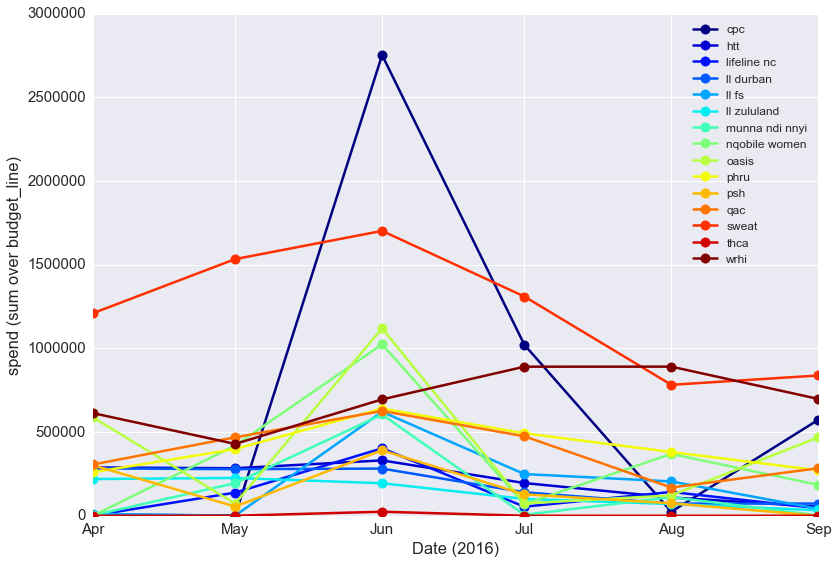

In [7]:
#plot spending per region

#setup colors
start,stop=0,1
number_of_colors= len(plot_spend.index.levels[0])
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

fig=figure()
fig.set_size_inches(13, 9)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for level,color in zip(plot_spend.index.levels[0],colors):
    plt.plot(plot_spend[level],'.-',color=color,markersize=20, label=level,)
ylabel('spend (sum over budget_line)')
xlabel('Date (2016)')
legend(loc='upper right', numpoints=1,fontsize=12)
ax = gca()
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
#yscale('log')


<h1> Group by quarter </h1>

In [8]:
plot_spend=DF.loc[(DF['field']=='spend') & (DF['year']<=2016) & (DF['Quarter']<=2)].groupby(['subrecipient','Quarter']).sum()['val']
plot_spend

subrecipient    Quarter
cpc             1          2.759530e+06
                2          1.618566e+06
htt             1          9.026696e+05
                2          3.580400e+05
lifeline nc     1          5.417175e+05
                2          2.402625e+05
ll durban       1          8.422708e+05
                2          2.850366e+05
ll fs           1          6.321698e+05
                2          4.950573e+05
ll zululand     1          6.386447e+05
                2          2.029758e+05
munna ndi nnyi  1          8.012208e+05
                2          1.188548e+05
nqobile women   1          1.443221e+06
                2          6.233507e+05
oasis           1          1.778952e+06
                2          6.631024e+05
phru            1          1.297509e+06
                2          1.143940e+06
psh             1          7.465358e+05
                2          2.018028e+05
qac             1          1.400363e+06
                2          9.266312e+05
sweat           

(0, 3)

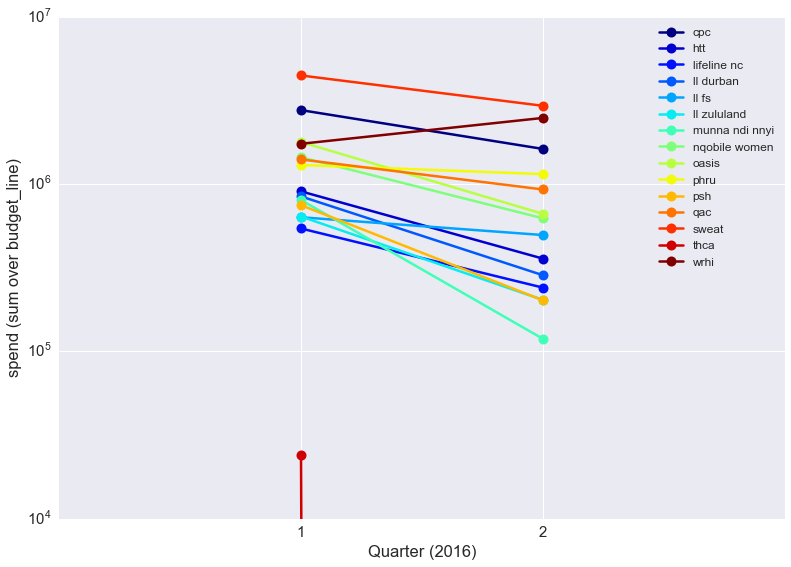

In [9]:
#plot spending per region

#setup colors
start,stop=0,1
number_of_colors= len(plot_spend.index.levels[0])
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

fig=figure()
fig.set_size_inches(13, 9)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for level,color in zip(plot_spend.index.levels[0],colors):
    plt.plot(plot_spend[level],'.-',color=color,markersize=20, label=level,)
ylabel('spend (sum over budget_line)')
xlabel('Quarter (2016)')
legend(loc='upper right', numpoints=1,fontsize=12)
ax = gca()
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
yscale('log')
xticks([1,2])
xlim(0,3)

<h1> Plot quarterly spending on pie char </h1>

In [39]:
def pie_spend(q):
    
    quarter = q

    pie_plot=plot_spend[:,q] #get quartly breakdown
    
    #Make d3 graph
    
    # Open File to write the D3 Graph
    kwargs1 = {"fontSize": '100'}

    chart = pieChart(width=700, height=600, **kwargs1)
    xdata = pie_plot.index
    #xdata = ['one' , 'two', 'three', 'four']
    ydata1 = pie_plot.values
    extra_serie = {"tooltip": {"y_start": "", "y_end": " cal"}}

    chart.add_serie(title='Q1',name="Serie 1", y=ydata1, x=xdata, extra=extra_serie,**kwargs1)
    chart.buildhtml()

    print('Spending fraction \n Quarter: {:d}'.format(quarter))
    display(chart)

In [40]:
interact(pie_spend, q=(1,2,1) )

Spending fraction 
 Quarter: 2


<h1> </h1>